In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [176]:
# Import the training data and testing datasets
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [177]:
#rows of training dataset
traindf.shape

(891, 12)

In [178]:
#rows of test dataset
testdf.shape

(418, 11)

In [179]:
#Genral structure of training dataset
traindf.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [180]:
#Genral structure of test dataset
testdf.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [181]:
#inspect basic statstics of training dataset
traindf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [182]:
#inspect basic statstics of test dataset
testdf.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [183]:
#Get categorical variables
def describe_categorical(traindf):
    from IPython.display import display, HTML
    display(HTML(traindf[traindf.columns[traindf.dtypes == "object"]].describe().to_html()))
describe_categorical(traindf)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [184]:
#Get categorical variables
def describe_categorical(testdf):
    from IPython.display import display, HTML
    display(HTML(testdf[testdf.columns[testdf.dtypes == "object"]].describe().to_html()))
describe_categorical(testdf)

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Rosenbaum, Miss. Edith Louise",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [185]:
#Number of total missing values in train dataset
traindf.isnull().T.any().T.sum()

708

In [186]:
#Number of missing values in train dataset
traindf.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [187]:
#Number of total missing values in test dataset
testdf.isnull().T.any().T.sum()

331

In [188]:
#Number of missing values in test dataset
testdf.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [189]:
#Target dataframe
y = traindf.pop('Survived')

In [190]:
# Fill missing values with the means of the continuous features
traindf['Ticket'].interpolate(method='linear', inplace=True)

In [191]:
# Fill missing values in train dataset
missing_variables = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for trainvariable in missing_variables:
    traindf[trainvariable].fillna(traindf[trainvariable].mean(), inplace=True)

In [192]:
#Convert categorical data into dummy/numeric variables
categorical_variables = ['Sex']
for trainvariable in categorical_variables:
    # Fill missing data with the word "Missing"
    traindf[trainvariable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(traindf[trainvariable], prefix=None)
    # Update testdf to include dummies and drop the main variable
    traindf = pd.concat([traindf, dummies], axis=1)
    traindf.drop([trainvariable], axis=1, inplace=True)

In [193]:
#Again, check the number of missing values in the training datatset
traindf.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
female           0
male             0
dtype: int64

In [194]:
#Drop the unwanted variables
traindf.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [195]:
#Show all the columns in train dataset
def printall(traindf, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(traindf.to_html(max_rows=max_rows))) 
printall(traindf)

,Pclass,Age,SibSp,Parch,Fare,female,male
0,3,22.000000,1,0,7.2500,0,1
1,1,38.000000,1,0,71.2833,1,0
2,3,26.000000,0,0,7.9250,1,0
3,1,35.000000,1,0,53.1000,1,0
4,3,35.000000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1
887,1,19.000000,0,0,30.0000,1,0
888,3,29.699118,1,2,23.4500,1,0
889,1,26.000000,0,0,30.0000,0,1


In [196]:
# Fill missing values with the means of the continuous features
testdf['Ticket'].interpolate(method='linear', inplace=True)

In [197]:
# Fill missing values in train dataset
missing_variables = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for testvariable in missing_variables:
    testdf[testvariable].fillna(testdf[testvariable].mean(), inplace=True)

In [198]:
#Convert categorical data into dummy/numeric variables
categorical_variables = ['Sex']
for testvariable in categorical_variables:
    # Fill missing data with the word "Missing"
    testdf[testvariable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(testdf[testvariable], prefix=None)
    # Update testdf to include dummies and drop the main variable
    testdf = pd.concat([testdf, dummies], axis=1)
    testdf.drop([testvariable], axis=1, inplace=True)

In [199]:
#Drop the unwanted variables
testdf.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

In [200]:
#Show all the columns in test dataset
def printall(testdf, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(testdf.to_html(max_rows=max_rows)))
    
printall(testdf)

,Pclass,Age,SibSp,Parch,Fare,female,male
0,3,34.50000,0,0,7.8292,0,1
1,3,47.00000,1,0,7.0000,1,0
2,2,62.00000,0,0,9.6875,0,1
3,3,27.00000,0,0,8.6625,0,1
4,3,22.00000,1,1,12.2875,1,0
...,...,...,...,...,...,...,...
413,3,30.27259,0,0,8.0500,0,1
414,1,39.00000,0,0,108.9000,1,0
415,3,38.50000,0,0,7.2500,0,1
416,3,30.27259,0,0,8.0500,0,1


In [201]:
#Again, check the number of missing values in the test datatset
testdf.isnull().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
female    0
male      0
dtype: int64

In [202]:
#Build Model
X_train, X_test, y_train, y_test = train_test_split(traindf, y, test_size=.2, random_state=42)

In [203]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
print("R^2: ", model1.score(X_test, y_test).round(4))

('R^2: ', 0.82679999999999998)


In [204]:
model1.feature_importances_

array([ 0.07125275,  0.25253982,  0.0529499 ,  0.03451314,  0.29359984,
        0.166512  ,  0.12863256])

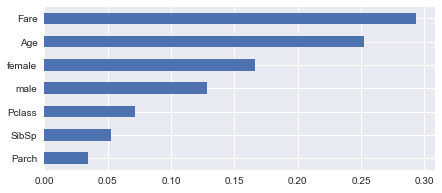

In [205]:
featureimportance = pd.Series(model1.feature_importances_, index=testdf.columns)
featureimportance.sort_values(inplace=True)
featureimportance.plot(kind='barh', figsize=(7,3))

In [206]:
### Grid Search
n_estimators = [300, 400, 500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [207]:
estimator.fit(traindf[:100000], y[:100000])

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [208]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [209]:
best_rfc = estimator.best_estimator_

In [210]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.960893854749


In [272]:
#Final Model
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features=0.9, 
                              min_samples_leaf=5)
model.fit(traindf, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

('C-stat: ', 0.86856485475985057)
